## Welcome! This is a tutorial notebook on how to patch images and text for BLIP, using NOTICE framework. 
### Please first follow the steps in the preprocessing folder to obtain the MIT states files needed for this notebook.

In [1]:
import pandas as pd
import argparse
import numpy as np
import pickle
from transformers import BlipProcessor
from patching_utils import *
from models_patching import *


/oscar/data/ceickhof/mgolovan/ib_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ModifiedBlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.to(device)
processor = BlipProcessor.from_pretrained('Salesforce/blip-vqa-base')


In [3]:
df_correct = pd.read_csv("BLIP_final_mit_states.csv").head(10)

In [5]:
# "output" is MLP patching, you can change this to "crossattention_block" or "attention_block" for cross-attention or self-attention patching. 
block_name = "text_encoder"
kind = "output"
mode = "image"

In [6]:
patching_images_results = debug_hidden_flow(model, processor, df_correct, block_name=block_name, kind=kind, start=0, end=12, mode=mode, attn_head=None,  image_tensors=None)


FINISHED PATCHING FOR KIND=output


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rapidfuzz import process, fuzz
from transformers import BlipProcessor
processor=BlipProcessor.from_pretrained('Salesforce/blip-vqa-base')

import matplotlib.pyplot as plt
import numpy as np

def plot_trace_heatmap_overlay(result, focus, title=None, xlabel=None, modelname=None, color='Purples', savepdf=None):
    differences = result["scores"]
    low_score = result["low_score"]
    differences = (differences - differences.min()) / (differences.max() - differences.min())
    block_name = str(result["block_name"])
    question = result["question"]

    # Constructing y-axis labels based on focus
    if focus:
        labels = ['[CLS]', 'Is', 'this', 'noun', 'correct_adj', 'or', 'incorrect_adj', '?', '[SEP]']
    else:
        labels = ['[CLS]', 'Is', 'this', 'noun', 'incorrect_adj', 'or', 'correct_adj', '?', '[SEP]']

    with plt.rc_context():  # Removed specific font family for general compatibility
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap=color,
            vmin=0.0,
        )
        ax.invert_yaxis()
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1], 1)])
        ax.set_xticklabels(list(range(0, differences.shape[1], 1)))
        ax.set_yticks([0.5 + i for i in range(len(labels))])
        ax.set_yticklabels(labels)

        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        cb.ax.text(0.5, -0.1, f"p(correct_adj)", ha='left', va='top', transform=cb.ax.transAxes, fontsize=8)
        
        plt.show()

def overlay_heatmaps(temp_list, focus, title, xlabel, block_name, color='Purples', savepdf=False):
    all_scores = [temp['scores'][:,:,0] for temp in temp_list]
    avg_scores = np.mean(all_scores, axis=0)
    
    avg_result = temp_list[0].copy()
    avg_result['scores'] = avg_scores
    
    plot_trace_heatmap_overlay(avg_result, focus, title, xlabel, block_name, color, savepdf)

def automate_heatmap_generation(df, emp_list, title, color='Purples', savepdf=False):
    df = df.reset_index()
    states = ['color', 'shape', 'texture']
    categories = [True, False]

    for state in states:
        for category in categories:
            filtered_df = df[(df['state'] == state) & (df['correct_first'] == category)]
            temp_list = [emp_list[i] for i in filtered_df.index if i < len(emp_list)]
            if temp_list:
                state_title = f"{title} - {state} - {'Correct First' if category else 'Incorrect First'}"
                overlay_heatmaps(temp_list, category, state_title, "Layers", "text_encoder", color, savepdf)
            else:
                print(f"No data for {state} with {'correct first' if category else 'incorrect first'}.")


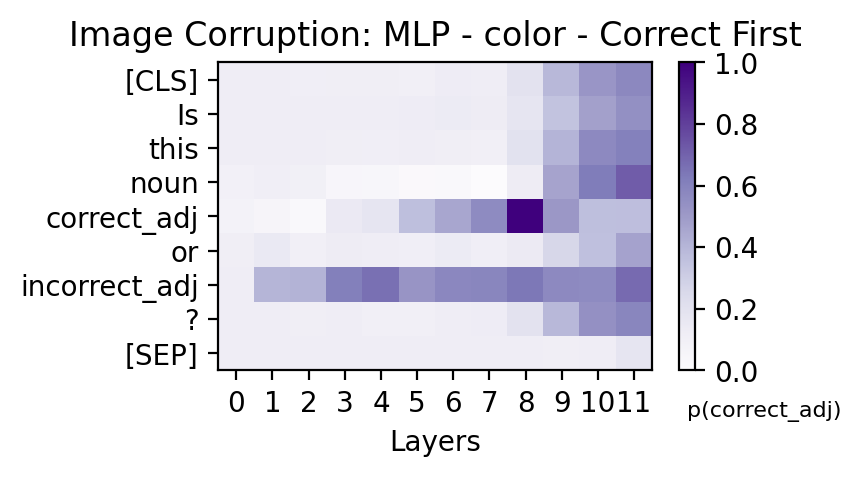

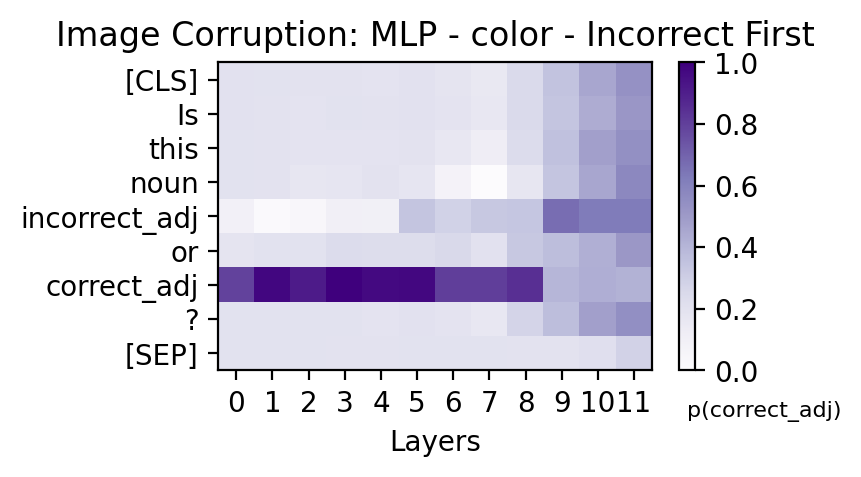

No data for shape with correct first.
No data for shape with incorrect first.
No data for texture with correct first.
No data for texture with incorrect first.


In [8]:
# NOTE: since this is just 10 samples, the data is not there for every type of plot. No need to worry! Just load more data in instead of using .head(10).
automate_heatmap_generation(df_correct, patching_images_results, "Image Corruption: MLP",
                            color='Purples', savepdf=None)

In [9]:
mode = "text"
patching_text_results = debug_hidden_flow(model, processor, df_correct, block_name=block_name, kind=kind, start=0, end=12, mode=mode, attn_head=None, knockout=None)


FINISHED PATCHING FOR KIND=output


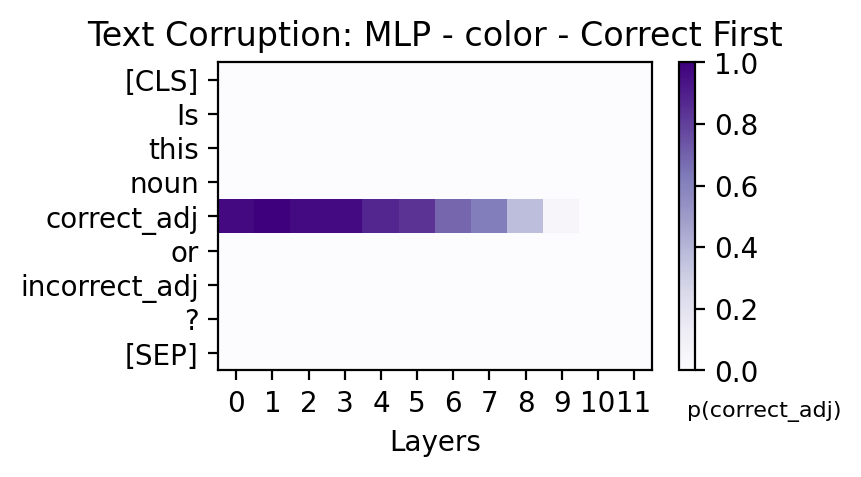

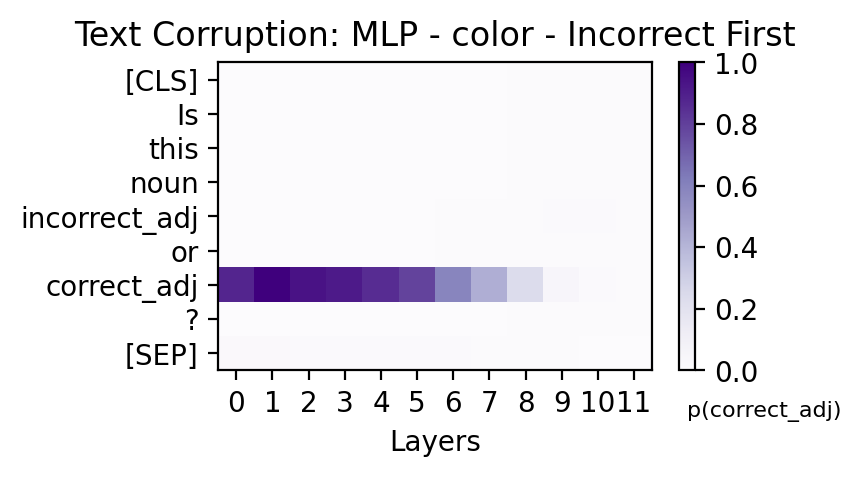

No data for shape with correct first.
No data for shape with incorrect first.
No data for texture with correct first.
No data for texture with incorrect first.


In [10]:
automate_heatmap_generation(df_correct, patching_text_results, "Text Corruption: MLP",
                            color='Purples', savepdf=None)